In [57]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from scipy.optimize import nnls, minimize
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


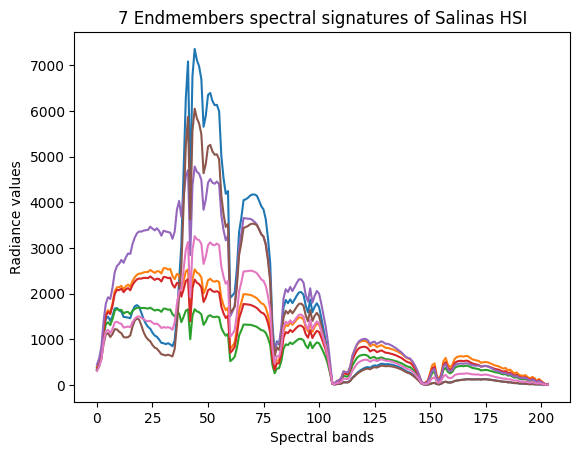

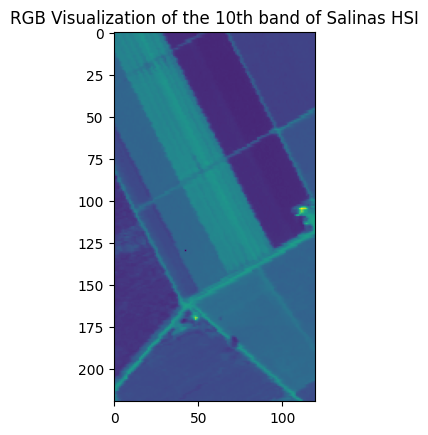

In [9]:
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

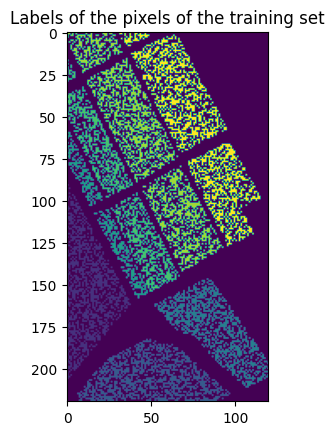

In [10]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [11]:
# Least Squares estimate with no constraints
def least_squares(X, y):
    theta, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    return theta

In [12]:
# Least Squares estimate with sum-to-one constraint
def least_squares_sum_to_one(X, y):
    n = X.shape[1]
    
    # Objective function: ||X*theta - y||^2
    def objective(theta):
        return np.sum((X @ theta - y) ** 2)
    
    # Initial guess
    theta0 = np.ones(n) / n
    
    # Constraint: sum of coefficients = 1
    constraint = {'type': 'eq', 'fun': lambda theta: np.sum(theta) - 1}
    
    result = minimize(objective, theta0, constraints=[constraint], method='SLSQP')
    return result.x

In [13]:
#  Least Squares estimate with non-negativity constraint
def least_squares_nonneg(X, y):
    theta, residuals = nnls(X, y)
    return theta

In [14]:
# Least Squares estimate with non-negativity and sum-to-one constraints
def least_squares_nonneg_sum_to_one(X, y):
    n = X.shape[1]
    
    # Objective function: ||X*theta - y||^2
    def objective(theta):
        return np.sum((X @ theta - y) ** 2)
    
    # Initial guess (uniform positive summing to 1)
    theta0 = np.ones(n) / n
    
    # Bounds: all parameters >= 0
    bounds = [(0, None) for _ in range(n)]
    
    # Constraint: sum of coefficients = 1
    constraint = {'type': 'eq', 'fun': lambda theta: np.sum(theta) - 1}
    
    result = minimize(objective, theta0, bounds=bounds, constraints=[constraint], method='SLSQP')
    return result.x

In [15]:
# Lasso estimate
def lasso(X, y):
    model = Lasso(alpha=0.01, tol=1e-2, positive=True)
    model.fit(X, y)
    coeffs = model.coef_
    
    # Handle the zero-sum case
    if np.sum(coeffs) == 0:
        return np.zeros_like(coeffs)
    
    # Normalize to sum to one
    return coeffs / np.sum(coeffs)

In [16]:
# Unmixing function
def unmix_matrix(endmembers, HSI, labels, method="Least Squares"):
    height, width = labels.shape
    X = endmembers
    n_endmembers = endmembers.shape[1]
    total_error = 0
    pixel_count = 0
    # Initialize the 
    abundance_map = np.zeros((height,width,n_endmembers))

    # Iterate all pixels in the image
    for i in range(height):
        for j in range(width):
            if labels[i,j] != 0:
                y = HSI[i,j,:]

                if method == "Least Squares":
                    theta = least_squares(X, y)
                elif method == "Least Squares Sum-to-One":
                    theta = least_squares_sum_to_one(X, y)
                elif method == "Least Squares Non-Negative":
                    theta = least_squares_nonneg(X, y)
                elif method == "Least Squares Non-Negative Sum-to-One":
                    theta = least_squares_nonneg_sum_to_one(X, y)
                elif method == "Lasso":
                    theta = lasso(X, y)
                else:
                    raise ValueError("Invalid method")
            
                abundance_map[i,j,:] = theta

                reconstructed = X @ theta
                error = np.sum((y - reconstructed)**2)
                total_error += error
                pixel_count += 1

    # Calculate average error
    avg_error = total_error / pixel_count if pixel_count > 0 else 0

    return abundance_map, avg_error

In [22]:
# Plot the results of the unmixing
def plot_abundance_map(abundance_map,  materials):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    # Flatten axes for easier indexing
    axes = axes.ravel()

    # Plot the theta values for each material
    for i in range(7):
        im = axes[i].imshow(abundance_map[:, :, i])
        axes[i].set_title(f'{materials[i+1]}')
        plt.colorbar(im, ax=axes[i])  

    # Sum the thetas for each pixel
    sum_abundance_map = np.sum(abundance_map, axis=2, keepdims=True)

    # Plot the sum of the theta values
    im = axes[7].imshow(sum_abundance_map[:, :, 0])
    axes[7].set_title(f'Sum of theta values')
    plt.colorbar(im, ax=axes[7])  

    # Plot the ground truth labels 
    im = axes[8].imshow(Training_Set)
    axes[8].set_title('Label Map (Ground Truth)')
    cbar = plt.colorbar(im, ticks=np.arange(1, len(materials) + 1))
    cbar.set_label("Cluster")
    cbar.set_ticklabels(materials)
    
    plt.show()

In [45]:
# Map of materials
materials = {
    1: 'Grapes',
    2: 'Broccoli',
    3: 'Fallow 1',
    4: 'Fallow 2',
    5: 'Fallow 3',
    6: 'Stubble',
    7: 'Celery'
}
errors_df = pd.DataFrame()

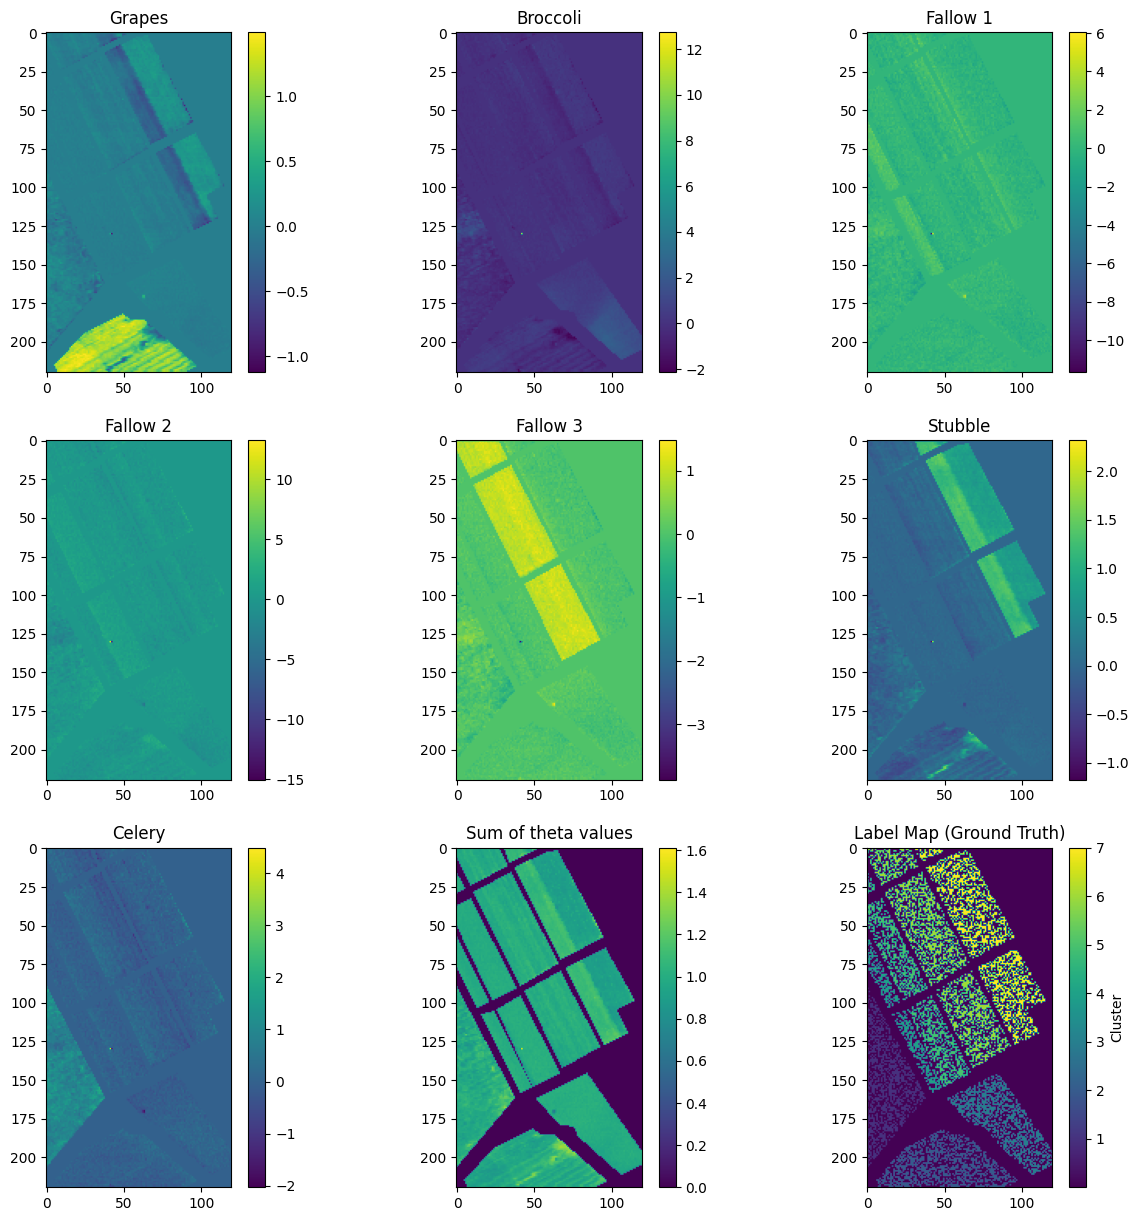

Average reconstruction error:  35058.880662772615


In [23]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels)
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Least Square'] = round(reconstruction_error, 2)

We can observe that by using the `Least Squares with no constraints` we can see both negative values and sums far from 1. While it might achieve good mathematical fits in some regions, the results lack physical meaning and have the highest reconstruction error, making this method impractical for out application. 

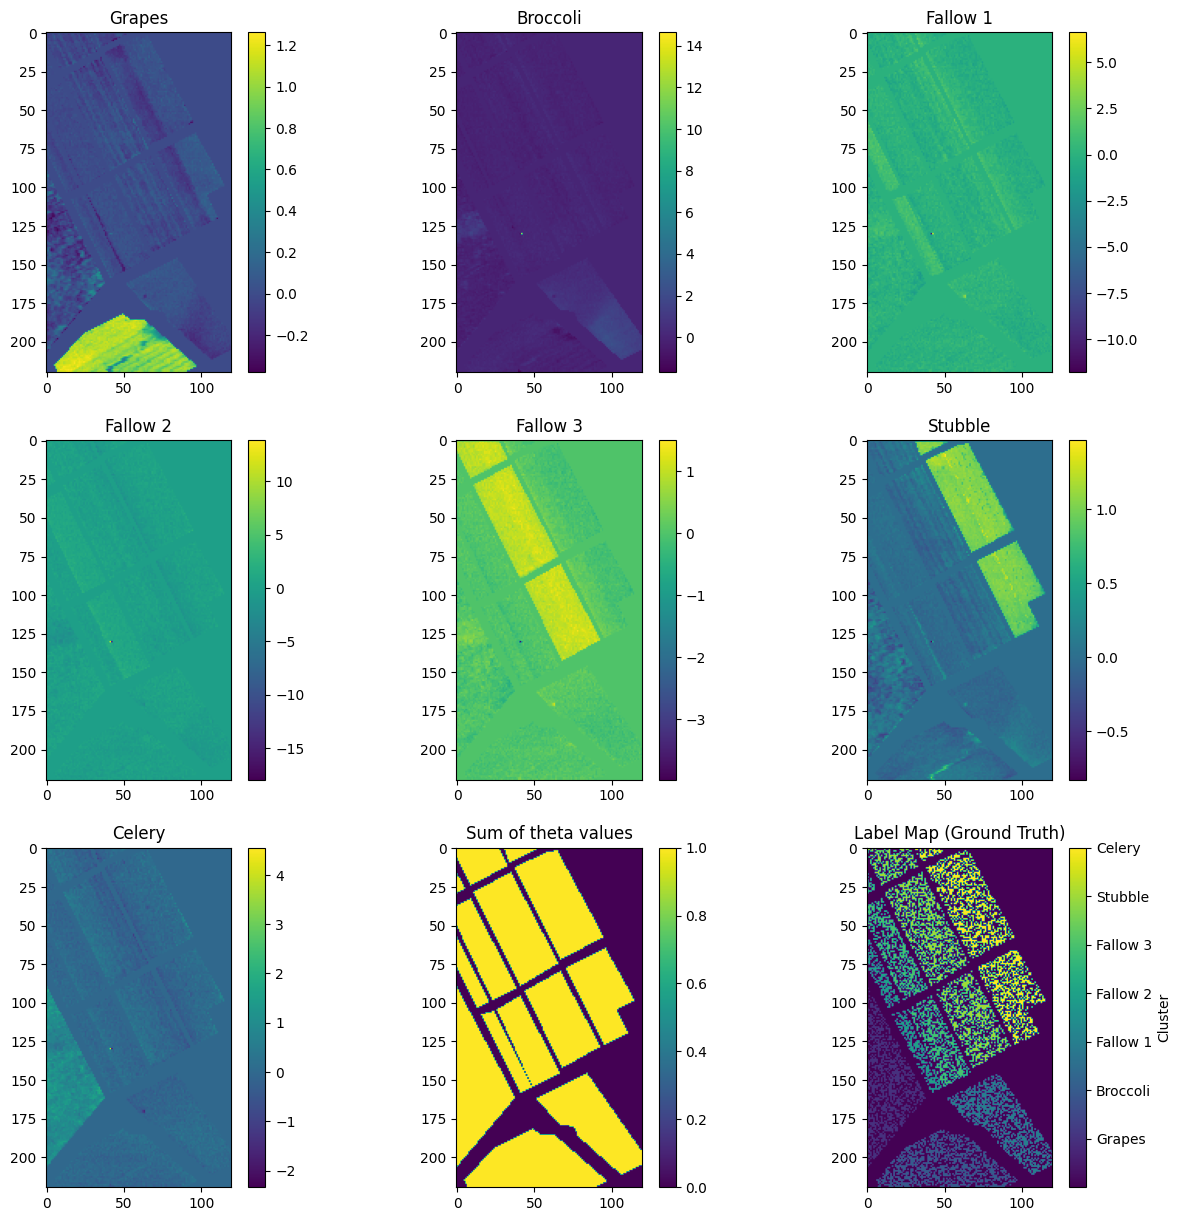

In [ ]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Sum-to-One")
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Sum-to-One'] = round(reconstruction_error, 2)

The results from the `Least Squares Sum-to-One only` reveal the importance of the non-negativity constraint, as it shows significant negative values (blue regions) despite maintaining sum-to-one. The high reconstruction error and physically impossible negative abundances make this method less suitable despite its mathematical validity.

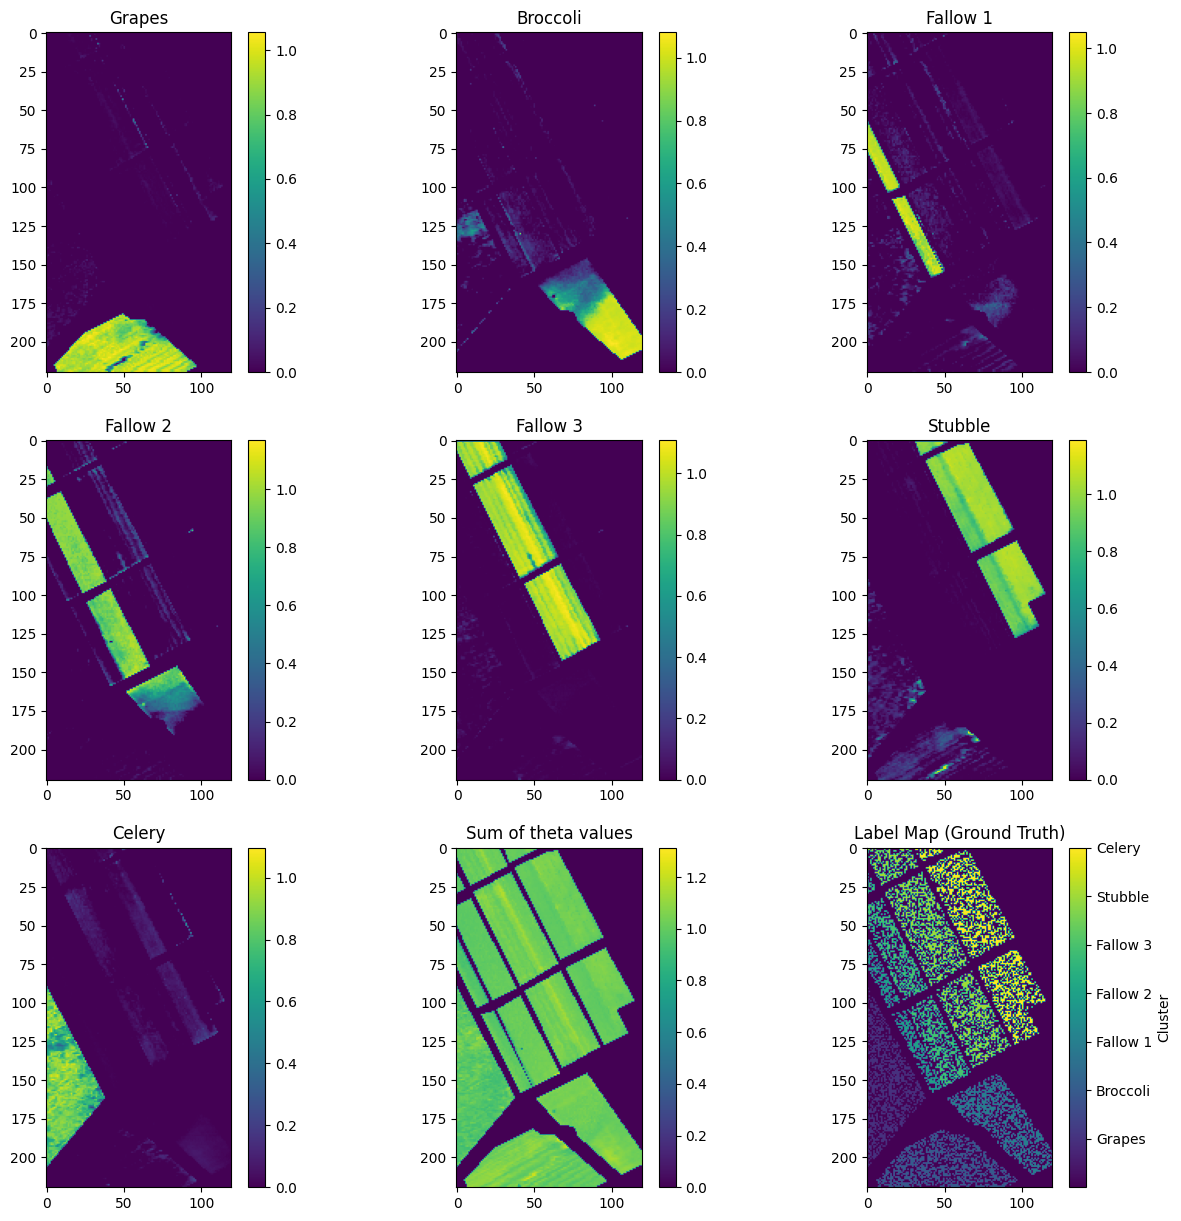

In [ ]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Non-Negative")
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Non-Negative'] = round(reconstruction_error, 2)

The results from the `Least Squares Non-negativity only`, show significant overlap between materials and some regions have abundance sums much higher than 1. While it maintains the important physical constraint of non-negative abundances, the lack of sum-to-one constraint leads to less interpretable results in terms of total material composition.

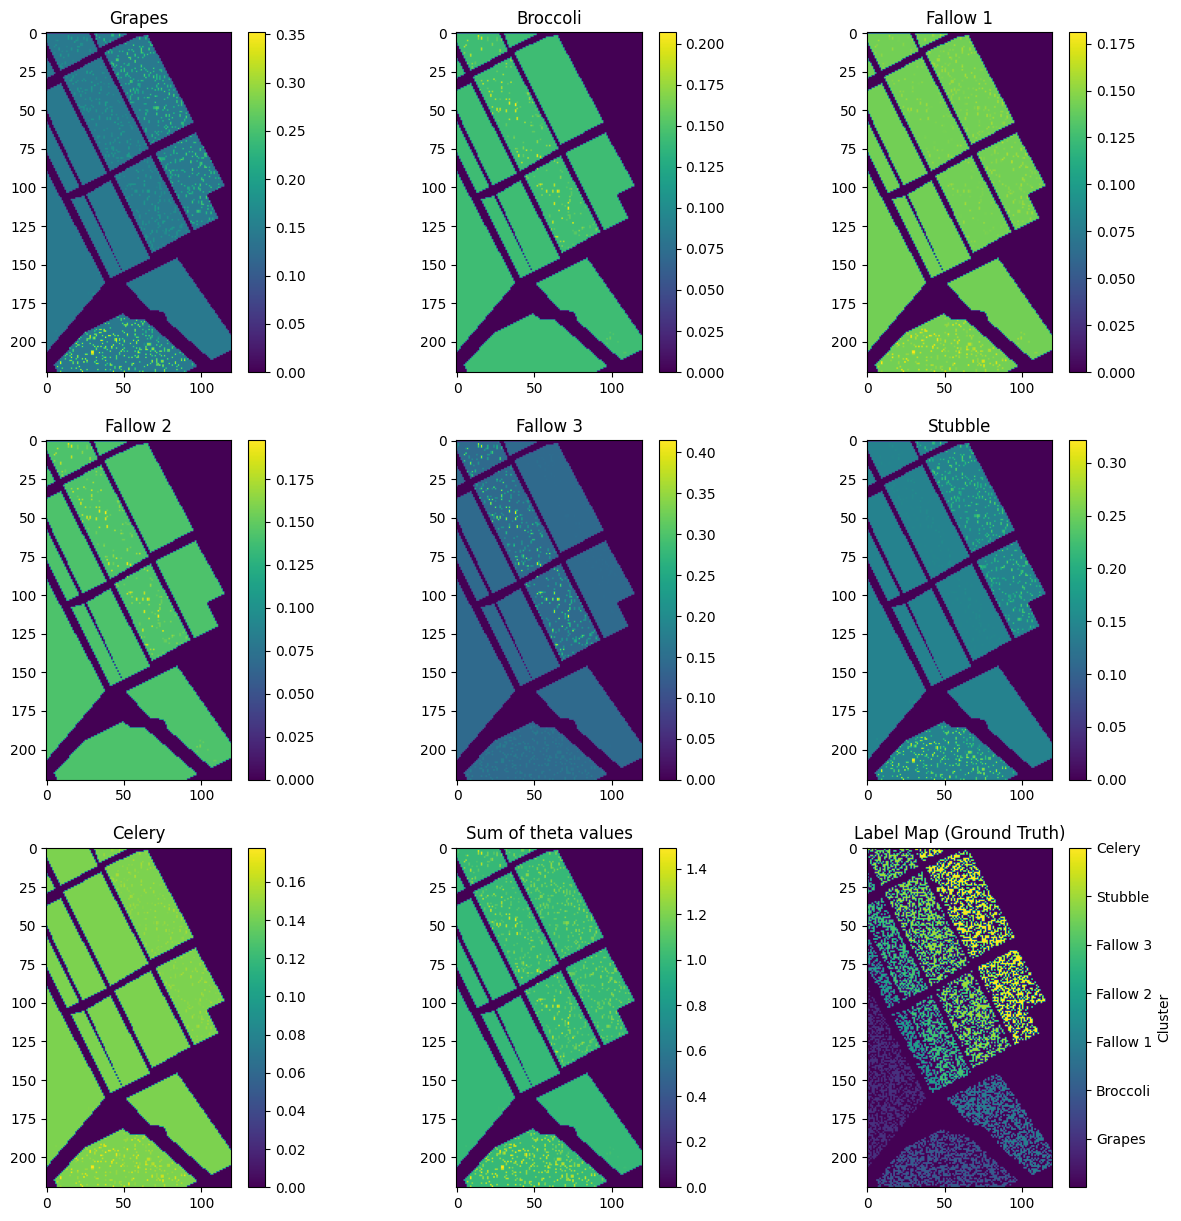

In [ ]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Non-Negative Sum-to-One")
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Non-Negative Sum-to-One'] = round(reconstruction_error, 2)

The results from the `Least Squares fully constrained` deomnstrate more mixed regions between materials, but maintain physical interpretability due to both non-negativity and sum-to-one constraints. While it has higher error, the abundance distributions appear more natural and show realistic transitions between different crop regions.

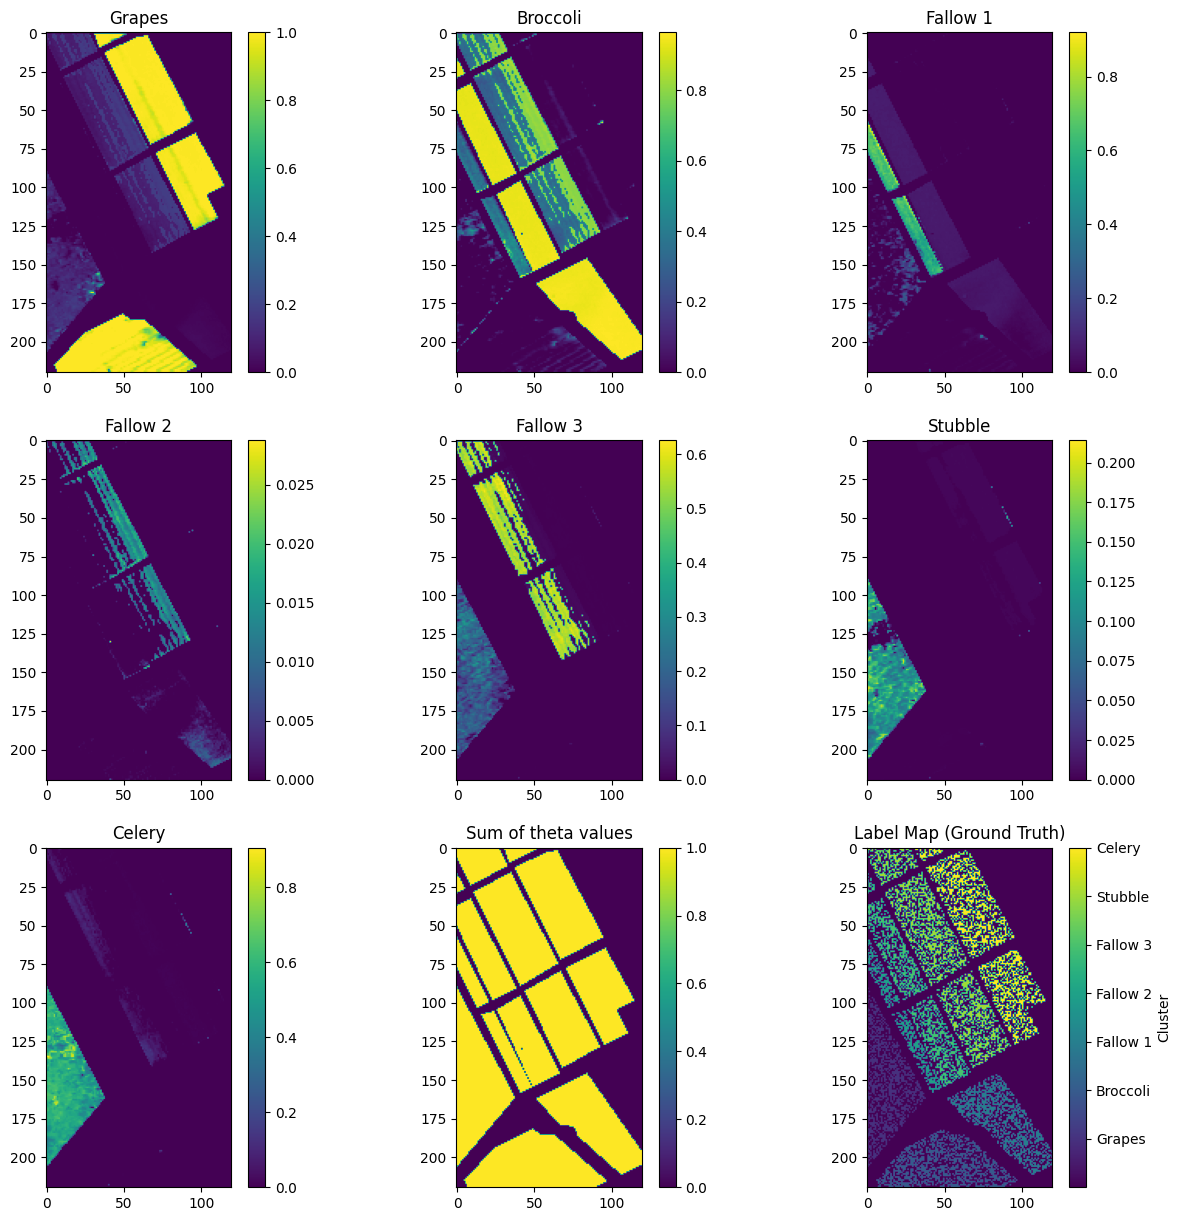

In [ ]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Lasso")
plot_abundance_map(abundance_map, materials)
print("Average reconstruction error: ", reconstruction_error)
errors_df.loc[0, 'Lasso'] = reconstruction_error

The results from the `Lasso Regression` show the most distinct separation between crop types with clean, sparce regions for each material. The abundance maps are highly interpretable, matching well with the ground truth. The **Sum of theta values** staying close to one indicates good physical meaning. Having the lowest reconstruction error while maintaining sparsity makes this method particularly effective for this application.

In [452]:
errors_df

,Least Square,Sum-to-One,Non-Negative,Non-Negative Sum-to-One,Lasso
0,35058.88,43082.58,156104.18,83294010.38,2.303926e+07


The `Average reconstruction errors` follow a clear pattern reflecting the impact of constraints.
  * The **Least squares method** achieves the lowest error but lacks physical constraints. 
  * Enforcing **sum-to-one** slightly increases error, while adding only **non-negativity** leads to a much higher error, due to reduced flexibility.
  * The combination of **sum-to-one and non-negativity** results in a drastic error rise, dute to over restricting the solution space.
  * LASSO enforces sparsity but yields a significantly higher error, suggesting that while constraints guide solutions toward physical plausibility, excessive restriction can negatively impact reconstruction accuracy.

In [64]:
# TODO: Delete this cell

# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

In [65]:
def prepare_data(train_set, test_set, salinas_cube):
  # Keep only the important labels
  train_mask = train_set != 0
  test_mask = test_set != 0

  # Get class labels
  y_train =  train_set[train_mask]
  y_test = test_set[test_mask]

  # Get spectral signatures for each labeled pixel
  X_reshaped = salinas_cube.reshape(salinas_cube.shape[0] * salinas_cube.shape[1], salinas_cube.shape[2])
  X_train = X_reshaped[train_mask.flatten()]
  X_test = X_reshaped[test_mask.flatten()]

  return X_train, X_test, y_train, y_test


In [80]:
class MinimumDistanceClassifier:
  def __init__(self):
    self.centroids = None
    self.classes = None

  def fit(self, X, y):
    self.classes = np.unique(y)
    self.centroids = np.array(
      [X[y == c].mean(axis=0) 
       for c in self.classes])
    
  def predict(self, X):
    distances = np.sqrt(((X[:, np.newaxis, :] - self.centroids) ** 2).sum(axis=2))
    return self.classes[np.argmin(distances, axis=1)]
  
  def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)
  
  def get_params(self, deep=True):
      """ Required for compatibility with scikit-learn """
      return {}

  def set_params(self, **params):
      """ Required for compatibility with scikit-learn """
      return self  # No parameters to update


In [76]:
# Method that performs 10-fold cross-validation
def evaluate_with_cross_validation(clf, X_train, y_train, name):
    cv_errors = 1 - cross_val_score(clf, X_train, y_train, cv=10)
    
    print(f"\n{name} - Cross Validation Results:")
    print(f"Mean validation error: {cv_errors.mean():.4f}")
    print(f"Standard deviation: {cv_errors.std():.4f}")
    
    return cv_errors

In [68]:
# Method that evaluates the classifier on the test set
def evaluate_on_test_set(clf, X_train, X_test, y_train, y_test, name):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    success_rate = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
    
    print(f"\n{name} - Test Set Results:")
    print(f"Success rate: {success_rate:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Identify poorly separated classes
    poor_separation = []
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            if i != j and conf_matrix[i,j] > 1:
                poor_separation.append((i+1, j+1, conf_matrix[i,j]))
    
    if poor_separation:
        print("\nPoorly separated classes:")
        for true_class, pred_class, count in poor_separation:
            print(f"Class {true_class} confused with Class {pred_class} ({count} pixels)")
    
    return conf_matrix, success_rate

In [69]:
X_train, X_test, y_train, y_test = prepare_data(Training_Set, Test_Set, HSI)

In [81]:
classifiers = {
    'Minimum Distance': MinimumDistanceClassifier(),
    # 'Naive Bayes': GaussianNB(),
    # 'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    # 'Bayesian': GaussianNB()
}

results = pd.DataFrame(columns=['cv_errors', 'confusion_matrix', 'success_rate'])
best_success_rate = 0
best_classifier = None

for name, clf in classifiers.items():
    print(f"\n{'='*50}")
    print(f"Evaluating {name} Classifier")
    print('='*50)
    
    # 1. Cross-validation
    cv_errors = evaluate_with_cross_validation(clf, X_train, y_train, name)
    
    # 2. Test set evaluation
    conf_matrix, success_rate = evaluate_on_test_set(
        clf, X_train, X_test, y_train, y_test, name
    )
    
    # Track best classifier
    if success_rate > best_success_rate:
        best_success_rate = success_rate
        best_classifier = (name, clf)
    
    results.loc[name] = {
        'cv_errors': cv_errors,
        'confusion_matrix': conf_matrix,
        'success_rate': success_rate
    }

# # 3. Use best classifier on operational set
# print(f"\n{'='*50}")
# print(f"Best Classifier: {best_classifier[0]} (Success Rate: {best_success_rate:.4f})")
# print(f"Evaluating Operational Set")
# print('='*50)

# best_clf = best_classifier[1]
# best_clf.fit(X_train, y_train)  # Retrain on full training set
# op_predictions, op_true_labels = predict_operational_set(
#     best_clf, Operational_Set, salinas_cube
# )


Evaluating Minimum Distance Classifier

Minimum Distance - Cross Validation Results:
Mean validation error: 0.0551
Standard deviation: 0.0768

Minimum Distance - Test Set Results:
Success rate: 0.9591
Confusion Matrix:
[[536   0   4   0   1   0   7]
 [  2 484   0   0   0   0  31]
 [  0   0 417   0  95   0   0]
 [  0   0   0 212   2   0   0]
 [  0   0  16   4 543   0   0]
 [  0   0   6   0   0 992   0]
 [  5   0   0   0   0   0 875]]

Poorly separated classes:
Class 1 confused with Class 3 (4 pixels)
Class 1 confused with Class 7 (7 pixels)
Class 2 confused with Class 1 (2 pixels)
Class 2 confused with Class 7 (31 pixels)
Class 3 confused with Class 5 (95 pixels)
Class 4 confused with Class 5 (2 pixels)
Class 5 confused with Class 3 (16 pixels)
Class 5 confused with Class 4 (4 pixels)
Class 6 confused with Class 3 (6 pixels)
Class 7 confused with Class 1 (5 pixels)


In [ ]:
# def predict_operational_set(clf, operational_set, salinas_cube):
#     """Predict classes for operational set using trained classifier"""
#     op_mask = operational_set != 0
#     X_reshaped = salinas_cube.reshape((220 * 120, 204))
#     X_operational = X_reshaped[op_mask.flatten()]
    
#     predictions = clf.predict(X_operational)
#     true_labels = operational_set[op_mask]
    
#     print("\nOperational Set Predictions:")
#     print(f"Number of pixels predicted: {len(predictions)}")
#     print("Class distribution:", np.unique(predictions, return_counts=True))
    
#     return predictions, true_labels